# Depth From Stereo


In the following depth from stereo has been implemented using the images provided in the the question. Since the 2 images are initially unrectified, their calibration is carried out using the calibrations camera matrices provided in 'camera.txt'. Once the pair of images have been rectified, the depth map is then computed using the defined disparity range and the edge weights which are in turned used for calculating data term and prior term. The weighting factor lambda of the prior term is calculated using edge weights. The data term, prior term and weighting factor in terms of the horizontal and vertical costs are then used for graphcut based segmentation using PyGCO package. 


Importing the necessary libraries:

In [3]:
#from pygco import cut_simple
import numpy as np
import cv2
import matplotlib.pyplot as plt
import gco
import os
os.add_dll_directory('C:/MinGW/bin')
from scipy.sparse import csr_matrix

In [4]:
img1 = plt.imread("test00.jpg")
img1=cv2.resize(img1,(480,270))
img2 = plt.imread("test09.jpg")
img2=cv2.resize(img2,(480,270))
(H,W)=img1.shape[0:2]
img2.shape

(270, 480, 3)

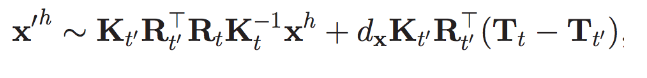


In [5]:
dmin=0
dmax=0.01
interval=dmax/100
epsilon = 50
disparity=np.arange(0,dmax+interval,interval)

In [6]:
f = open ( 'cameras.txt' , 'r')
l = []
l = [ line.split() for line in f if len(line.split())!=0]
print(l)

matrices=[]
for row in l:
    matrices.append([np.float32(val) for val in row])
matrices1=np.array(matrices)

img1 = plt.imread("test00.jpg")
img1=cv2.resize(img1,(480,270))
img2 = plt.imread("test09.jpg")
img2=cv2.resize(img2,(480,270))
(H,W)=img1.shape[0:2]
img2.shape

# img1=plt.imread('C:/Users/Varshini/AppData/Local/Programs/Python/Python38-32/Road/src/'+img_files[img1_idx])
# img1=cv2.resize(img1,(480,270))
#camera matrices
# K1=np.array(matrices[img1_idx *7+ 1 : img1_idx *7+ 4 ])
# R1=np.array(matrices[img1_idx *7+ 4 : img1_idx *7+ 7 ])
# T1=np.array(matrices[img1_idx *7+ 7])
# K2=np.array(matrices[img2_idx *7+ 1 : img2_idx *7+ 4 ])
# R2=np.array(matrices[img2_idx *7+ 4 : img2_idx *7+ 7 ])
# T2=np.array(matrices[img2_idx *7+ 7])

K1=matrices1[0:3]
R1=matrices1[3:6]
T1=np.array(matrices1[6])
K2=matrices1[7:10]
R2=matrices1[10:13]
T2=np.array(matrices1[13])

[['1221.2270770', '0.0000000', '479.5000000'], ['0.0000000', '1221.2270770', '269.5000000'], ['0.0000000', '0.0000000', '1.0000000'], ['1.0000000000', '0.0000000000', '0.0000000000'], ['0.0000000000', '1.0000000000', '0.0000000000'], ['0.0000000000', '0.0000000000', '1.0000000000'], ['0.0000000000', '0.0000000000', '0.0000000000'], ['1221.2270770', '0.0000000', '479.5000000'], ['0.0000000', '1221.2270770', '269.5000000'], ['0.0000000', '0.0000000', '1.0000000'], ['0.9998813487', '0.0148994942', '0.0039106989'], ['-0.0148907594', '0.9998865876', '-0.0022532664'], ['-0.0039438279', '0.0021947658', '0.9999898146'], ['-9.9909793759', '0.2451742154', '0.1650832670']]


In [7]:
nx=4*np.ones([H,W])
#nx1=nx.copy()
nx[[0,-1], :] = nx[[0,-1], :] - 1
nx[:,[0,-1]] = nx[:,[0,-1]] - 1
#nx[:, 0:1] = nx[:,0:1] - 1
#nx_t=nx.T
nx_t1=nx.flatten()

In [14]:

eta = 0.05 * (max(disparity) - min(disparity));

[a, b] = np.meshgrid(disparity,disparity);
rho = np.minimum(abs(a - b), eta);


labelcost = rho;

In [8]:
import numpy.matlib
sigma_c = 10
row = np.matlib.repmat(np.arange(0,H), W, 1).T
row_flat=row.flatten().T
col = np.matlib.repmat(np.arange(0,W).T, 1, H)
col_flat=col.flatten().T

img1_coord_homo=np.vstack([col_flat,row_flat,np.ones(H*W)]).astype(np.int32)

In [9]:
differences=np.zeros((H,W,len(disparity)))

#construct graph for weights
index_arr=np.arange(0,H*W)
index_arr1=index_arr.reshape(H,W)
up= index_arr1[0:-1, :].astype(np.int32)
down=index_arr1[1:,:].astype(np.int32)
left= index_arr1[:,0:-1].astype(np.int32)
right=index_arr1[:,1:].astype(np.int32)
source=np.concatenate((up.flatten(), down.flatten(), left.flatten(), right.flatten()),axis=0)
target=np.concatenate((down.flatten(), up.flatten(), right.flatten(), left.flatten()),axis=0)
r = img1[:, :, 0]
r = r.flatten()
g = img1[:, :, 1]
g = g.flatten()
b = img1[:, :, 2]
b = b.flatten()
weights = np.square(r[source].astype(np.int32) - r[target].astype(np.int32)) +  np.square(g[source].astype(np.int32) - g[target].astype(np.int32)) + np.square(b[source].astype(np.int32) - b[target].astype(np.int32))
weights1 = np.divide(1 , (np.sqrt((weights.astype(np.int32))) + epsilon))
pairwise = csr_matrix((weights1,(source, target)))
non_zero_source_ind=pairwise.nonzero()[1]
denominator = np.sum(pairwise,axis=0)
u_lambda = nx_t1 / denominator

w_s = 2/ (disparity[-1] - disparity[0])
lambda_val = np.multiply(w_s ,np.multiply (np.array(u_lambda)[0][non_zero_source_ind] , weights1))

cost_v=lambda_val[0:W*(H-1)].reshape(H-1,W).astype(np.int32)
cost_h=lambda_val[2*W*(H-1):2*W*(H-1)+H*(W-1)].reshape(H,W-1).astype(np.int32)

#data term 

img1_pixel=img1[img1_coord_homo[1],img1_coord_homo[0]]
# img2_idx_range_vals = np.arange(img1_idx - num_neighbour/2,img1_idx + num_neighbour/2 +1,1).astype(np.int32)
# img2_range=[i for i in img2_idx_range_vals if (i>=0 and i!=img1_idx and i<140) ]
# differences=np.zeros((H,W,len(disparity)))
# #differences=np.zeros((H,W,len(disparity)))
# for i in range(0,len(img2_range)):
# img2_idx = img2_range[i]
# K2=np.array(matrices[img2_idx *7+ 1 : img2_idx *7+ 4 ])
# R2=np.array(matrices[img2_idx *7+ 4 : img2_idx *7+ 7 ])
# T2=np.array(matrices[img2_idx *7+ 7])
# img2=plt.imread('C:/Users/Varshini/AppData/Local/Programs/Python/Python38-32/Road/src/'+img_files[img2_idx])
# img2=cv2.resize(img2,(480,270))
# pc = np.zeros((H,W,len(disparity)))
for d in range(len(disparity)):

#for d in  np.arange(0,max_disp,0.00005):
#for d in np.arange(0,0.01,0.005):
    #img1_coord_reshape = np.reshape(img1_coord_homo, [3,-1])

    #d=np.reshape(disparity[i],[1,-1])
    #print(d)
    #depth = (T-T1).T * d 
#     img2_coord_homo=((K1@R1.T)@(R@np.linalg.inv(K))@img1_coord_homo)+ (disparity[d]*(K1@R1.T)@(T-T1).T)
    #img2_coord_homo=np.dot(np.dot(np.dot(K1,R1.T),np.dot(R,np.asmatrix(K).I)),img1_coord_homo) + (disparity[d]*np.dot((K1*R1.T),(T-T1).T))
    mult1=np.dot(K2,R2.T)
    mult2=np.dot(mult1,R1)
    mult3=np.dot(mult2,np.linalg.inv(K1))
    img2_coord_homo=np.dot(mult3,img1_coord_homo)+(disparity[d]*np.dot(np.dot(K2,R2.T),(T1-T2).T)).reshape(3,1)

#     img2_coord_homo=np.dot(np.dot(np.dot(np.dot(K1,R1.T),R),np.linalg.inv(K)),img1_coord_homo)
#     img2_coord_homo2=disparity[d]*np.dot(np.dot(K1,R1.T),(T-T1))
#     img2_coord_homo+=img2_coord_homo2
    #img2_coord_homo=(K2 @ R2.T @ R1@np.linalg.inv(K) @ img1_coord_homo) + d * K2 @ R2.T @ (T1 - T2).T
    img2_coord= img2_coord_homo/ img2_coord_homo[2, :][None,:]
    img2_coord = np.round(img2_coord_homo[0:2,:]).astype(np.int32)
#     img2_pixel=[]
    img2_coord[0][img2_coord[0]>W-1]=W-1
    img2_coord[1][img2_coord[1]>H-1]=H-1

    img2_pixel=img2[img2_coord[1],img2_coord[0]]
#     for k in range(img2_coord.shape[1]):
#         (y,x)=img2_coord[:,k]
#         if y<W and x<H and y>=0 and x>=0:
#             img2_pixel.append(img2[x,y])
#         else:
#             img2_pixel.append([0,0,0])
    #if disp == 0:

    #    diff = np.sqrt(np.sum((img1 - img2) ** 2, axis=2))
    #else:
    #diff = np.sqrt(np.sum((img1[:, 2 * (disp+1):, :] - img2[:, :-2 * (disp+1), :]) **
    #            2, axis=2))
    #diff=sigma_c / (sigma_c + np.sqrt(np.sum(np.square(np.array(img1_pixel).reshape([H,W,3])-np.array(img2_pixel).reshape([H,W,3]),dtype=np.float32), axis=-1)))
    #diff=sigma_c / (sigma_c + np.sqrt(np.sum(np.square(img1-img2_proj,dtype=np.float32), axis=-1)))
    #diff=sigma_c / (sigma_c + np.sqrt(np.sum(np.square(np.array(img1_pixel)-np.array(img2_pixel),dtype=np.float32), axis=-1)))
    l2 = np.sqrt(np.sum((img1_pixel-img2_pixel)**2,axis=1))
    diff=sigma_c/(sigma_c+l2)
    differences[:,:,d]=diff.reshape(H,W)
differences=1-differences/np.max(differences)


In [10]:
x, y = np.ogrid[:101, :101]
one_d_topology = np.abs(x - y).astype(np.int32).copy("C")

Plotting the result

0 129598 129599 1 129600


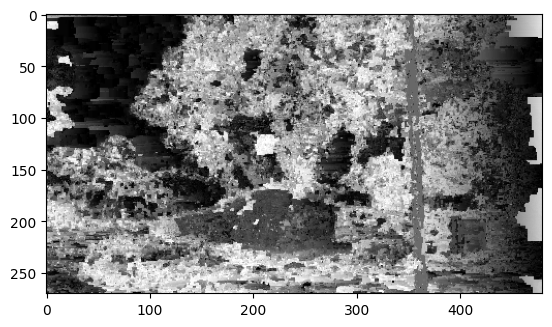

In [11]:
labels= gco.cut_grid_graph_simple(
     400*differences,one_d_topology,
    n_iter=-1,
    algorithm='swap'
    
)

plt.imshow(labels.reshape(H,W),cmap='gray')

0 129598 129599 1 129600


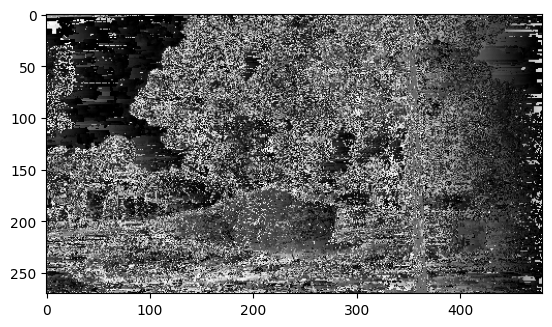

In [15]:
labels= gco.cut_grid_graph(
     400*differences,50*rho,
    cost_v,
    cost_h,
    n_iter=-1,
    algorithm='swap'
    
)

plt.imshow(labels.reshape(H,W),cmap='gray')

From the plot above , it can be seen that the results are not as good as expected. I have checked all parameters and I have spent an extensive amount of time to check the steps followed for computation of data term and prior term as well. However, the expected results may not have come since I had issues during installation of pygco package. The plot seems to be better while using the python wrapper for the pygco package as well. A lot of memory errors and kernel errors were also face along the way as a result of which images had to be downscaled.

0 129598 129599 1 129600


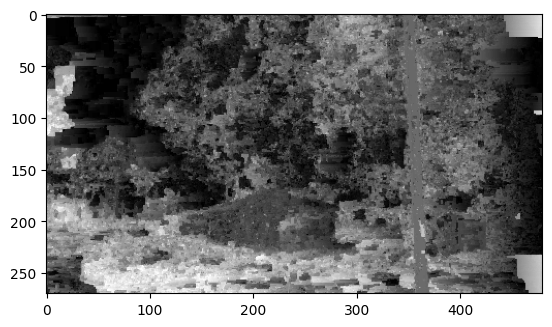

In [26]:
labels= gco.cut_grid_graph_simple(
     100*differences,0.5*one_d_topology,
    n_iter=-1,
    algorithm='swap'
    
)

plt.imshow(labels.reshape(H,W),cmap='gray')

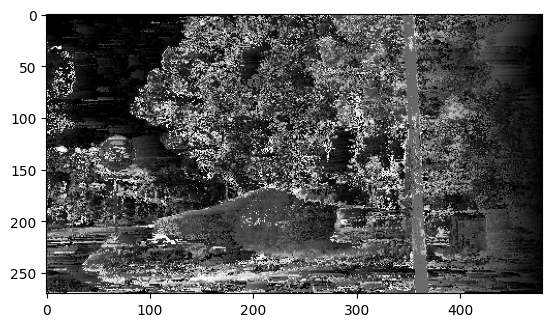

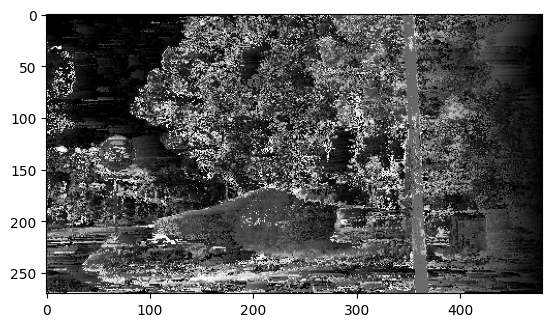

In [61]:
plt.imshow((min_index).astype(int).reshape([H,W]),cmap='gray')

From the plot above , it can be seen that the results are not as good as expected. I have checked all parameters and I have spent an extensive amount of time to check the steps followed for computation of data term and prior term as well. However, the expected results may not have come since I had issues during installation of pygco package. The plot seems to be better while using the python wrapper for the pygco package as well. A lot of memory errors and kernel errors were also face along the way as a result of which images had to be downscaled.